In [1]:
import random
import sympy as sp
import json
import numpy as np
import matplotlib.pyplot as plt

# Liste des opérateurs binaires et des fonctions unaires
OPERATORS = ['+', '-', '*', '/']
FUNCTIONS = ['sin', 'cos', 'exp', 'sqrt']

# Générateur récursif d'expressions mathématiques
def generate_expression(depth=3):
    if depth == 0:
        # Cas de base : on retourne soit une variable, soit une constante
        return random.choice(['x', str(random.randint(1, 10))])
    
    # Choix d'une structure d'expression (opérateur binaire ou fonction unaire)
    expr_type = random.choice(['binary', 'unary'])
    
    if expr_type == 'binary':
        # Générer une expression binaire
        op = random.choice(OPERATORS)
        left = generate_expression(depth - 1)
        right = generate_expression(depth - 1)
        return f"({left} {op} {right})"
    
    elif expr_type == 'unary':
        # Générer une expression unaire
        func = random.choice(FUNCTIONS)
        inner_expr = generate_expression(depth - 1)
        return f"{func}({inner_expr})"

In [4]:
# Exemple de génération
expression = generate_expression(depth=3)
print("Expression générée :", expression)

# Optionnel : convertir l'expression en une expression sympy
sympy_expr = sp.sympify(expression)
print("Expression sous forme SymPy :", sympy_expr)

Expression générée : ((exp(x) - (x * 2)) * ((4 + x) - (2 - x)))
Expression sous forme SymPy : (-2*x + exp(x))*(2*x + 2)


In [56]:
def evaluate_expression(expr, num_points=10, x_range=(-10, 10)):
    x = sp.symbols('x')
    sympy_expr = sp.sympify(expr)
    points = []
    for _ in range(num_points):
        x_val = random.uniform(*x_range)
        try:
            y_val = float(sympy_expr.subs(x, x_val))
            points.append((x_val, y_val))
        except (ZeroDivisionError, ValueError):
            continue  # Ignorer les erreurs mathématiques
    return points

# Génération et stockage de plusieurs expressions avec leurs points d'échantillonnage
def generate_dataset(num_expressions=100, depth=3, num_points=10, x_range=(-10, 10)):
    dataset = []
    for _ in range(num_expressions):
        expr = generate_expression(depth)
        points = evaluate_expression(expr, num_points, x_range)
        dataset.append({
            'expression': expr,
            'points': points
        })
    return dataset

# Sauvegarder le dataset dans un fichier JSON
def save_dataset_to_json(dataset, filename="dataset.json"):
    with open(filename, 'w') as f:
        json.dump(dataset, f, indent=4)



In [66]:
# Exemple d'utilisation
dataset = generate_dataset(num_expressions=10, depth=3, num_points=10, x_range=(-10, 10))
save_dataset_to_json(dataset)
print("Dataset généré et sauvegardé dans dataset.json")

Dataset généré et sauvegardé dans dataset.json


In [2]:
# Génération d'arbres binaires aléatoires
class TreeNode:
    def __init__(self, value=None, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __repr__(self):
        if self.left is None and self.right is None:
            return str(self.value)
        else:
            return f"{self.value} {self.left} {self.right}"

def add_children(lis, place):
    lis.insert(place+1, None)
    lis.insert(place+2, None)

#distribution as in article where n_max = D_max (10) + b_max (5)
def distrib_binary_tree(n_max=15):
    distrib = np.zeros((n_max+2,n_max+1))
    distrib[0][1:] = 0
    distrib[1:,0] = 1
    for sum in range(2,n_max+2):
        for j in range(1,sum):
            i = sum - j
            distrib[i][j] = distrib[i-1][j] + distrib[i+1][j-1]
    return distrib
    
def generate_binary_tree(n,bin_list):
    tree = [None]
    e = 1
    distrib = distrib_binary_tree(n)

    while n>0 :
        k = random.choices(range(e), weights=[distrib[e-i+1,n-1]/distrib[e,n] for i in range(e)])[0]
        i = 0
        count = k
        while count >=0 :
            if count==0 and tree[i] is None :
                tree[i] = bin_list.pop(0)
                add_children(tree, i)
                count -= 1
            elif tree[i] is None :
                tree[i] = 'Leaf'
                i += 1
                count -= 1
            else :
                i += 1
            
        e = e - k + 1
        n -= 1
    
    for i in range(len(tree)):
        if tree[i] is None :
            tree[i] = 'Leaf'
    return tree   


In [109]:
tree = generate_binary_tree(5, ['+', '-', '*', '+', '-'])
print(tree)

['+', '-', 'Leaf', '*', '+', 'Leaf', 'Leaf', 'Leaf', '-', 'Leaf', 'Leaf']


In [3]:
D_MAX = 2
u_max = 10
N_MAX = 100
BINARY = ['+', '-', '*']
UNARY = ['inv','abs', 'sqr','sqrt','sin', 'cos', 'tan','arctan','log', 'exp']
PRECISION = 2
VARIABLES = [f'x{i}' for i in range(D_MAX)]
SYMBOLS = list(sp.symbols(' '.join(VARIABLES)))

def insert_multi(position, list1, list2):
    return list1[:position] + list2 + list1[position:]

def generate_integer(precision=2, max_exp=1):
    sign = random.choice([-1,1])
    mantissa = random.randint(1,10**precision)
    min_power = -max_exp - (precision + 1) // 2
    max_power = max_exp - (precision + 1) // 2
    exponent = random.randint(min_power, max_power+1)
    return round(sign * mantissa * 10**exponent, precision)

#generation as in article
def generate_expression_2() :
    D = random.randint(1, D_MAX)
    variables = VARIABLES[:D]
    b_max = 5 + D
    b = random.randint(D-1, D+b_max)
    binary = random.choices(BINARY, weights=[1,1,1], k=b)

    expr = generate_binary_tree(b,binary)
    #print(expr)
    i = 0
    while i < len(expr) :
        if expr[i] == 'Leaf' :
            x = random.choice(variables)
            m, p = generate_integer(PRECISION), generate_integer(PRECISION)
            expr.pop(i)
            expr = insert_multi(i, expr, ['+','*',m,x,p]) 
        i += 1

    u = random.randint(0, u_max)
    #print(u)
    unary = random.choices(UNARY, weights=[5,1,3,3,1,1,0.2,0.2,0.2,1], k=u)
    while len(unary) > 0 :
        i = random.randint(0, len(expr)-1)
        una = unary.pop(0)
        m, p = generate_integer(PRECISION), generate_integer(PRECISION)
        expr = insert_multi(i, expr, ['+',p,'*',m,una])

    return expr,D

In [44]:
expr,D = generate_expression_2()
print(expr) 

['*', '*', '-', '-', '+', '*', -55, 'x0', -6.8, '+', '*', 4.2, 'x0', 22, '+', '*', 0.75, 'x0', -79, '*', '+', '*', 14, '+', 940, '*', -0.91, 'sqrt', 'x0', 190, '+', '*', -25, 'x0', 14, '-', '+', '*', -39, 'x0', 5.7, '+', '*', 190, 'x0', 0.98]


In [4]:
def pref_to_inf(expr):
    stack = []
    for i in range(len(expr)-1,-1,-1):
        e = expr[i]
        if e in BINARY:
            right = stack.pop()
            left = stack.pop()
            stack.append(f"({left} {e} {right})")
        elif e in UNARY:
            right = stack.pop()
            stack.append(f"{e}({right})")
        else :
            stack.append(str(e))
    return stack[0]

In [199]:
pref_to_inf(expr)

'((((((990 + (x2 * -120)) - (130 + (x4 * 0.19))) + ((42 + (x0 * -20)) + (90 + (x4 * -0.04)))) * ((82 + (x2 * -0.73)) - (-8.4 + (x0 * -0.9)))) * (((-8.3 + (((cos(x4) * 37) + 910) * -4.3)) + (340 + (x0 * -0.85))) + (-53 + (x3 * 59)))) - (((sqr((-29 + (x0 * 760))) * 60) + 600) - ((sqr(((5 + (x5 * 0.79)) + (0.82 + (x5 * 75)))) * 0.85) + 68)))'

In [5]:
class Sqr(sp.Function):
    @classmethod
    def eval(cls, x):
        return x ** 2
    
class Inv(sp.Function):
    @classmethod
    def eval(cls, x):
        return 1 / x
    
class Abs(sp.Function):
    @classmethod
    def eval(cls, x):
        return sp.Abs(x)

def simplify(expr, variables):
    infixed_expr = pref_to_inf(expr)
    symbol_dict = {str(var): var for var in variables}
    symbol_dict['inv'] = Inv
    symbol_dict['sqr'] = Sqr
    symbol_dict['abs'] = Abs
    sympy_expr = sp.sympify(infixed_expr, locals=symbol_dict)
    return sp.simplify(sympy_expr)

In [200]:
simplify(expr, SYMBOLS)

-60*(760*x0 - 29)**2 + 4882.505485*(x5 + 0.076791133394907)**2 + (0.9*x0 - 0.73*x2 + 90.4)*(0.85*x0 - 59*x3 + 159.1*cos(x4) + 3634.3)*(20*x0 + 120*x2 + 0.23*x4 - 992) - 532

In [53]:
simplify(generate_expression_2()[0], SYMBOLS)

-8.56226699660104e+21*x0**4 - 1.10248344159859e+27*x0**3 - 3.54890002064973e+31*x0**2 + 8.56828215397609e+30*x0 - 6.42032839225101e+29 + 8.81674021101686e+27/x0 + 6.45431683827804e+26/x0**2 - 1.10062716806675e+25/x0**3 - 2.75741341637633e+23/x0**4

In [18]:
K_MAX = 10

def haar_random_matrix(n):
    Z = np.random.randn(n, n)
    Q, R = np.linalg.qr(Z)
    if np.linalg.det(Q) < 0:
        Q[:, 0] = -Q[:, 0]
    return Q
     

def generate_input_point(D):
    N = random.randint(10*D, N_MAX)
    k = random.randint(1, K_MAX)
    w = np.random.uniform(0, 1, k)
    w = w / np.sum(w)
    x = np.zeros((0,D)) 
    print(N,k)
    for i in range(k):
        mu = np.random.uniform(0, 1, D)
        sigma = np.random.uniform(0, 1, D)
        distrib = np.random.choice(['normal', 'uniform'])
        if distrib == 'normal':
            number_points = int(np.floor(N * w[i]))
            haar_rotation = haar_random_matrix(number_points)
            sampled_points = np.random.normal(mu, sigma, (number_points,D))
            new_points = np.matmul(haar_rotation, sampled_points)
            x = np.vstack((x, new_points))
        else:
            lower_bound = mu - np.sqrt(3) * sigma
            upper_bound = mu + np.sqrt(3) * sigma
            number_points = int(np.floor(N * w[i]))
            haar_rotation = haar_random_matrix(number_points)
            sampled_points = np.random.uniform(lower_bound, upper_bound, (number_points,D))
            new_points = np.matmul(haar_rotation, sampled_points)
            x = np.vstack((x, new_points))
    normalized_x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return normalized_x

66 9


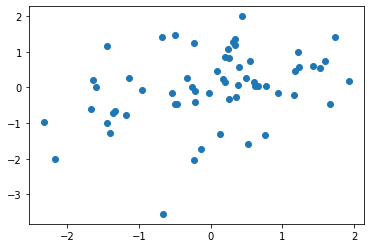

In [57]:
x = generate_input_point(2)
plt.figure()

plt.scatter(x[:,0], x[:,1])
plt.show()